importing Jupyter notebook from Takens.ipynb


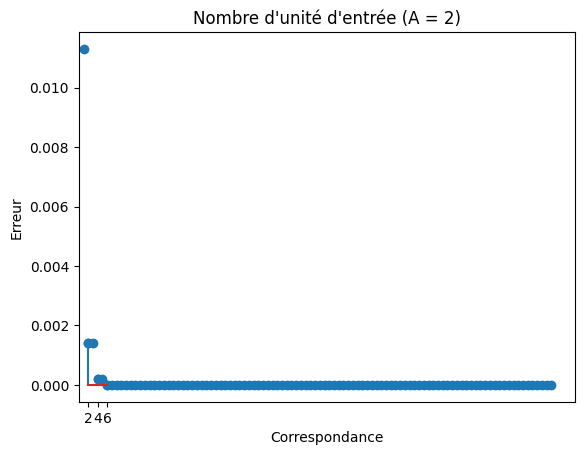

In [1]:
import numpy as np
import import_ipynb
import Takens
import matplotlib.pyplot as plt

In [2]:
def sigmoid(x):
    res = np.round((1 / (1 + np.exp(-x))), 8)
    return np.nan_to_num(res) if np.isinf(res) or np.isnan(res) else res


def d_sigmoid(x):
    res = np.round((np.exp(-x) / np.power((1 + np.exp(-x)), 2)), 8)
    return np.nan_to_num(res) if np.isinf(res) or np.isnan(res) else res


def generate_weight(source_units, target_units):
    return np.array(
        [
            np.round(np.random.uniform(0.1, 10 ** (-20)), 8)
            for _ in range(source_units * target_units)
        ]
    ).reshape(target_units, source_units)

In [3]:
def generate_network_weight(arch):
    return [generate_weight(arch[i - 1], arch[i]) for i in range(1, len(arch))]

In [4]:
def forward_propagation(prototype, weight):
    """Calcule les valeurs d'entrée et de sortie des unités de chaque couche
    Args:
        prototype (list[float]): prototype qui entre dans les noeuds de la couche d'entrée
        weight (list[list[float]]): poids de chaque connexions entre les noeuds des couches
            eg: Pour un réseau de type [3, 2, 1] w doit ressembler à
                w = [[[w11, w12, w13], [w21, w22, w23]], [[w11, w12]]]
    Returns:
        units_input (list[list[float]]): chaque valeurs d'entrée des unités de chaque couche
            eg: Pour un réseau de type [3, 2, 1] on a [[h21, h22], [h31]]
        units_output (list[list[float]]): chaque valeurs de sortie des unités de chaque couche
            eg: Pour un réseau de type [3, 2, 1] on a [[V11, V12, V13], [V21, V22], [V31]]
    """
    units_input = []
    units_output = [prototype]
    for layer in weight:
        current_input = []
        current_output = []
        for unit in layer:
            h = np.dot(prototype, unit)
            current_input.append(h)
            current_output.append(sigmoid(h))
        units_input.append(current_input)
        units_output.append(current_output)
        prototype = current_output
    return (units_input, units_output)

In [5]:
def output_layer_delta(input, output, desired_output):
    """Calcule les deltas pour la couche de sortie
    Args:
        input (list[float]): valeurs d'entrées des unités de sortie
        output (list[float]): valeurs produites par les unités de sortie
        desired_output (list[float]): valeurs désirés
    Returns:
        units_delta (list[float]): deltas des unités de la couche de sortie
    """
    units_delta = []
    for i in range(len(desired_output)):
        delta = d_sigmoid(input[i]) * (desired_output[i] - output[i])
        delta = (
            np.nan_to_num(np.round(delta, 8))
            if np.isinf(np.round(delta, 8)) or np.isnan(np.round(delta, 8))
            else np.round(delta, 8)
        )
        units_delta.append(delta)
    return units_delta

In [6]:
def middle_layer_delta(input, weight, succ_delta):
    """Calcule les deltas pour les couches précédentes
    Args:
        input (list[list[float]]): chaque valeurs d'entrée des unités de chaque couche
        weight (list[list[float]]): poids de chaque connexions entre les noeuds des couches
        succ_delta (list[list[float]]): delta des couches suivants
    Returns:
        succ_delta (list[list[float]]): liste de tous les deltas
    """
    units_delta = []
    for i in range(len(weight) + 1, 2, -1):
        for j in range(len(weight[i - 3])):
            delta = d_sigmoid(input[i - 3][j]) * np.dot(
                [weight[i - 2][k][j] for k in range(len(weight[i - 2]))], succ_delta[-1]
            )
            delta = (
                np.nan_to_num(np.round(delta, 8))
                if np.isinf(np.round(delta, 8)) or np.isnan(np.round(delta, 8))
                else np.round(delta, 8)
            )
            units_delta.append(delta)
        succ_delta.append(units_delta)
    return succ_delta

In [7]:
def delta_weight(learning_step, succ_layer_delta, output):
    """Calcule  delta weight pour mettre à jour les poids
    Args:
        learning_step (float): pas d'apprentissage
        succ_layer (list[list[float]]): tous les deltas de chaque noeud de chaque couche
        output (list[list[float]]): valeus produites par tous les noeuds
    Returns:
        delta_weights (list[list[float]]): delta de tous les noeuds de chaque couche
    """
    output_copy = list.copy(output)
    output_copy.pop()
    output_copy.reverse()
    delta_weights = []
    for i in range(len(succ_layer_delta)):
        current_delta = []
        for delta in succ_layer_delta[i]:
            current_delta.append(np.multiply(delta * learning_step, output_copy[i]))
        delta_weights.append(current_delta)
    delta_weights.reverse()
    return delta_weights

In [8]:
def update_weight(weight, delta_weight):
    """Met à jours les poids des connexions
    Args:
        weight (list[list[float]]): poids des connexions
        delta_weight (list[list[float]]): delta de tous les noeuds de chaque couche
    Returns: poids des connexions à jour
    """
    return [np.round(np.add(weight[i], delta_weight[i]), 8) for i in range(len(weight))]

In [9]:
def train(prototype, initial_weight, learning_step, desired_output):
    w = initial_weight
    outputs = []
    for i in range(len(desired_output)):
        unit_inputs, unit_outputs = forward_propagation(
            prototype=prototype[i], weight=w
        )
        outputs.append(unit_outputs[-1])
        delta = output_layer_delta(
            input=unit_inputs[-1],
            output=unit_outputs[-1],
            desired_output=desired_output[i],
        )
        delta = middle_layer_delta(input=unit_inputs, weight=w, succ_delta=[delta])
        dw = delta_weight(
            learning_step=learning_step, succ_layer_delta=delta, output=unit_outputs
        )
        w = update_weight(weight=w, delta_weight=dw)
    return (w, outputs)

In [10]:
def quadratic_error(prototype_number, variance_series, desired_outputs, outputs):
    return np.nan_to_num(
        (1 / (prototype_number * np.power(variance_series, 2)))
        * np.power(np.sum(np.subtract(outputs, desired_outputs)), 2)
    )

In [11]:
def train_with_epoch(prototype, initial_weight, learning_step, desired_output, epoch):
    w = [initial_weight]
    quadratic_errors = []
    for _ in range(epoch):
        nw, outputs = train(
            desired_output=desired_output,
            initial_weight=w[-1],
            learning_step=learning_step,
            prototype=prototype,
        )
        quadratic_errors.append(
            quadratic_error(
                prototype_number=len(desired_output),
                variance_series=0.1,
                desired_outputs=desired_output,
                outputs=outputs,
            )
        )
        w.append(nw)
    return (w, quadratic_errors)

In [12]:
def predict(prototype, desired_output, weight, length):
    prediction = []
    outputs = []
    for i in range(length):
        current_prediction = forward_propagation(prototype=prototype[i], weight=weight)[
            1
        ][-1]
        prediction.append(current_prediction)
        outputs.append(desired_output[i])
    return (prediction, outputs)

In [13]:
def predict_with_step_forward(prototype, desired_output, step, weight):
    used_prototype = np.array(prototype)
    prediction = []
    outputs = []
    for i in range(step):
        current_prediction = forward_propagation(
            prototype=used_prototype, weight=weight
        )[1][-1]
        prediction.append(current_prediction)
        outputs.append(desired_output[i])
        used_prototype = np.append(current_prediction, used_prototype)
        used_prototype = np.delete(used_prototype, -1)
    return (prediction, outputs)

In [14]:
def plot_prediction(prototype, step, weight, desired_output, a_value=2, length=10):
    prediction, _desired_output = (
        predict(
            prototype=prototype,
            length=length,
            weight=weight,
            desired_output=desired_output,
        )
        if step == 1
        else predict_with_step_forward(
            prototype=prototype[0],
            desired_output=desired_output,
            step=step,
            weight=weight,
        )
    )
    fig, ax = plt.subplots()
    ax.plot(np.array(range(len(_desired_output))), np.array(_desired_output).flatten())
    ax.plot(np.array(range(len(prediction))), np.array(prediction).flatten())
    ax.set_xlabel("Itération")
    ax.set_ylabel("Valeur")
    ax.legend(["Valeur attendue", "Valeur prédite"], loc="lower right")
    plt.title(f"Prédiction à {step} pas en avant (A = {a_value})")
    plt.show()

In [15]:
val = Takens.generate_func_values(a=2, initial_value=0.1, range_number=500)
seq = Takens.generate_sequence(time_series=val, dimension=2, delay=1).flatten()
learning_step = 0.1

In [16]:
arch = [(2,1,1), (2,2,1), (2,3,1), (2,4,1), (2,5,1)]
W = []
Q_ERRORS = []
for a in arch:
    prototype = seq.reshape(int(len(seq) / a[0]), a[0])
    desired_output = np.array([[val[i]] for i in range(a[0], len(val))])
    initial_weight = generate_network_weight(a)
    _, q_errors = train_with_epoch(
        initial_weight=initial_weight,
        learning_step=learning_step,
        desired_output=desired_output,
        prototype=prototype,
        epoch=1
    )
    Q_ERRORS.append(q_errors)
    

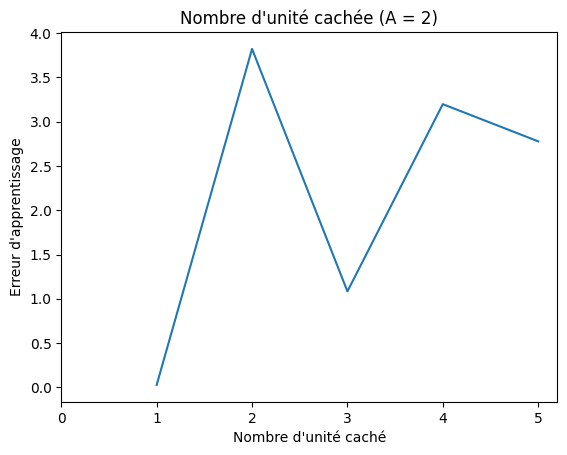

In [17]:
fig, ax = plt.subplots()
ax.set_xlabel("Nombre d'unité caché")
ax.set_ylabel("Erreur d'apprentissage")
ax.plot(np.array(range(1, len(arch)+1)), np.nan_to_num(Q_ERRORS))
plt.title(f"Nombre d'unité cachée (A = 2)")
ax.set_xlim(left=0)
plt.show()

In [18]:
initial_weight = generate_network_weight((2,1,1))
desired_output = np.array([[val[i]] for i in range(a[0], len(val))])
prototype = seq.reshape(int(len(seq) / 2), 2)
w, q_errors = train_with_epoch(
    initial_weight=initial_weight,
    learning_step=learning_step,
    desired_output=desired_output,
    prototype=prototype,
    epoch=20
)

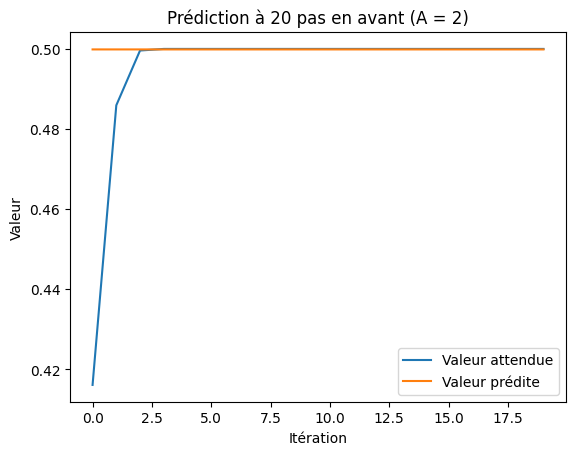

In [19]:
plot_prediction(prototype=prototype, step=20, weight=w[-1], desired_output=desired_output)